# MUSIC GAN

## INITIALIZATION

### Imports

In [1]:
import music21
import os
import pickle as pkl
import keras
import tensorflow as tf
from typing import (
    List, 
    Tuple, 
    Optional, 
    Union,
    Any
)
import requests
import glob
from tensorflow.keras import(
    layers,
    models,
    losses,
    callbacks
)
import numpy as np
import matplotlib.pyplot as plt
import datetime
from fractions import Fraction

2024-12-08 00:06:39.943382: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-08 00:06:39.971133: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 00:06:39.971161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 00:06:39.972117: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 00:06:39.977296: I tensorflow/core/platform/cpu_feature_gua

### Const

In [2]:
PARSE_MIDI_FILES= True
PARSED_DATA_PATH='./datasets/bach-cello-parseed/'
DATA_PATH='./datasets/bach-cello/'
LOG_PATH= './logs/fit/music_gan/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
CHECKPOINT_PATH= './checkpoints/'
DATASET_REPETTIOTIONS= 1
SEQ_LEN= 50
EMBEDDING_DIM= 256
KEY_DIM= 256
N_HEADS= 5
DROPOUT_RATE= 0.3
FEED_FORWARD_DIM= 256
LOAD_MODEL= False

# Optimization
EPOCHS= 5000
BATCH_SIZE= 256
GENERATE_LEN= 50

### Functions

In [3]:
def parse_midi_files(
    file_list: List[str],
    parser: music21.converter.Converter,
    seq_len: int,
    parsed_data_path: Optional[str] = None
) -> Tuple[List[str], List[str]]:
    """
    Parses a list of MIDI files and extracts note sequences and their corresponding durations.

    Args:
        file_list (List[str]): A list of file paths to MIDI files to be parsed.
        parser (music21.converter.Converter): A music21 parser object to read and process the MIDI files.
        seq_len (int): The length of the note and duration sequences to be generated.
        parsed_data_path (Optional[str]): Path to save the parsed note and duration sequences (if provided).

    Returns:
        Tuple[List[str], List[str]]: A tuple containing two lists:
            - notes_list: A list of note sequences of length `seq_len`.
            - duration_list: A list of corresponding duration sequences of length `seq_len`.
    """
    notes_list = []  # List to store sequences of notes
    duration_list = []  # List to store sequences of durations
    notes = []  # Temporary list to hold notes for a single file
    durations = []  # Temporary list to hold durations for a single file

    # Loop through each MIDI file in the file list
    for i, file in enumerate(file_list):
        print(i + 1, f'Parsing {file}')
        score = parser.parse(file).chordify()  # Convert the score to chords

        # Add a start token to the sequence
        notes.append('START')
        durations.append('0.0')

        # Iterate over the flattened elements of the score
        for element in score.flat:
            note_name = None
            duration_name = None

            # Determine the type of musical element and extract the note and duration
            if isinstance(element, music21.key.Key):
                note_name = f"{element.tonic.name}:{element.mode}"  # Extract key signature
                duration_name = '0.0'
            elif isinstance(element, music21.meter.TimeSignature):
                note_name = f"{element.ratioString}TS"  # Extract time signature
                duration_name = '0.0'
            elif isinstance(element, music21.chord.Chord):
                note_name = element.pitches[-1].nameWithOctave  # Use the highest pitch in the chord
                duration_name = str(element.duration.quarterLength)
            elif isinstance(element, music21.note.Rest):
                note_name = str(element.name)  # Extract rest
                duration_name = str(element.duration.quarterLength)
            elif isinstance(element, music21.note.Note):
                note_name = element.nameWithOctave  # Extract note with octave
                duration_name = str(element.duration.quarterLength)

            # Append note and duration if both were successfully extracted
            if note_name and duration_name:
                notes.append(note_name)
                durations.append(duration_name)

        print(f'{len(notes)} notes parsed')  # Log the number of parsed notes

    # Generate sequences of notes and durations of length `seq_len`
    print(f'Building sequences of length {seq_len}')
    for i in range(len(notes) - seq_len):
        notes_list.append(' '.join(notes[i: i + seq_len]))
        duration_list.append(' '.join(durations[i: i + seq_len]))

    # Create the directory if it doesn't exist
    os.makedirs(parsed_data_path, exist_ok=True)

    # Save the parsed sequences to files if `parsed_data_path` is provided
    if parsed_data_path:
        with open(os.path.join(parsed_data_path, 'notes.pkl'), 'wb') as f:
            pkl.dump(notes_list, f)
        with open(os.path.join(parsed_data_path, 'durations.pkl'), 'wb') as f:
            pkl.dump(duration_list, f)

    return notes_list, duration_list

def load_parsed_files(parsed_data_path: str) -> Tuple[List[str], List[str]]:
    """
    Loads the parsed note and duration sequences from pickle files.

    Args:
        parsed_data_path (str): The directory path where the parsed files ('notes' and 'durations') are stored.

    Returns:
        Tuple[List[str], List[str]]: A tuple containing:
            - notes (List[str]): A list of note sequences.
            - durations (List[str]): A list of corresponding duration sequences.
    """
    # Load the note sequences from the pickle file
    with open(os.path.join(parsed_data_path, 'notes'), 'rb') as f:
        notes = pkl.load(f)

    # Load the duration sequences from the pickle file
    with open(os.path.join(parsed_data_path, 'durations'), 'rb') as f:
        durations = pkl.load(f)

    return notes, durations

def get_midi_note(sample_note: str, sample_duration: str) -> music21.note.NotRest:
    """
    Converts a sample note and its duration into a corresponding Music21 note, chord, rest, or key signature object.

    Args:
        sample_note (str): The name of the note or musical element (e.g., 'C4', 'rest', 'C4.E4.G4' for a chord, or '4/4TS').
        sample_duration (str): The duration of the note in terms of quarter length, represented as a string (e.g., '0.5', '1', '1.5').

    Returns:
        new_note (music21.note.Note, music21.chord.Chord, music21.key.Key, or music21.meter.TimeSignature): 
        A Music21 object corresponding to the provided note and duration.
    """
    new_note = None

    # Handle Time Signature (e.g., '4/4TS')
    if 'TS' in sample_note:
        new_note = music21.meter.TimeSignature(sample_note.split('TS')[0])

    # Handle Key Signature (e.g., 'C:major', 'A:minor')
    elif 'major' in sample_note or 'minor' in sample_note:
        tonic, mode = sample_note.split(':')
        new_note = music21.key.Key(tonic, mode)

    # Handle Rest
    elif sample_note == 'rest':
        new_note = music21.note.Rest()
        new_note.duration = music21.duration.Duration(float(Fraction(sample_duration)))
        new_note.storedInstrument = music21.instrument.Violoncello()

    # Handle Chord (e.g., 'C4.E4.G4')
    elif '.' in sample_note:
        notes_in_chord = sample_note.split('.')
        chord_notes = []

        for current_note in notes_in_chord:
            n = music21.note.Note(current_note)
            n.duration = music21.duration.Duration(float(Fraction(sample_duration)))
            n.storedInstrument = music21.instrument.Violoncello()
            chord_notes.append(n)

        new_note = music21.chord.Chord(chord_notes)

    # Handle Single Note (e.g., 'C4')
    elif sample_note != 'START':
        new_note = music21.note.Note(sample_note)
        new_note.duration = music21.duration.Duration(float(Fraction(sample_duration)))
        new_note.storedInstrument = music21.instrument.Violoncello()

    return new_note

def create_dataset(elements: List[str]) -> Tuple[tf.data.Dataset, layers.TextVectorization, List[str]]:
    """
    Creates a TensorFlow dataset from the input elements, batches and shuffles it,
    and applies a TextVectorization layer to convert text data into integer sequences.

    Args:
        elements (List[str]): A list of text data. Each element in the list represents a text sample.

    Returns:
        Tuple[tf.data.Dataset, layers.TextVectorization, List[str]]: A tuple containing:
            - ds (tf.data.Dataset): A batched and shuffled TensorFlow dataset.
            - vectorize_layer (layers.TextVectorization): A TextVectorization layer fitted to the dataset.
            - vocab (List[str]): The vocabulary extracted from the TextVectorization layer.
    
    Example:
        elements = ["hello world", "this is a test", "deep learning with tensorflow"]
        ds, vectorize_layer, vocab = create_dataset(elements)
    """
    
    # Convert the input elements into a TensorFlow dataset
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)  # Create dataset slices from input list
        .batch(BATCH_SIZE, drop_remainder=True)       # Batch the dataset with specified batch size, dropping the remainder
        .shuffle(1000)                                # Shuffle the dataset with a buffer size of 1000
    )

    # Initialize a TextVectorization layer to convert text into sequences of integers
    vectorize_layer = layers.TextVectorization(
        standardize=None,    # No text preprocessing or standardization
        output_mode='int'    # Output mode is integer indices for each token
    )

    # Fit the TextVectorization layer to the dataset to build the vocabulary
    vectorize_layer.adapt(ds)

    # Extract the vocabulary list from the TextVectorization layer
    vocab = vectorize_layer.get_vocabulary()  # Vocabulary is a list of words or tokens
    
    # Return the dataset, the fitted TextVectorization layer, and the vocabulary
    return ds, vectorize_layer, vocab

def prepare_inputs(notes: tf.Tensor, durations: tf.Tensor) -> Tuple[Tuple[tf.Tensor, tf.Tensor], Tuple[tf.Tensor, tf.Tensor]]:
    """
    Prepares input and target sequences for training by tokenizing notes and durations.

    Args:
        notes (tf.Tensor): A tensor of musical notes with shape (batch_size, sequence_length).
        durations (tf.Tensor): A tensor of note durations with shape (batch_size, sequence_length).

    Returns:
        Tuple[Tuple[tf.Tensor, tf.Tensor], Tuple[tf.Tensor, tf.Tensor]]: A tuple containing:
            - x (Tuple[tf.Tensor, tf.Tensor]): The input tensors (tokenized notes and durations) with the last token removed.
            - y (Tuple[tf.Tensor, tf.Tensor]): The target tensors (tokenized notes and durations) with the first token removed.

    Example:
        Suppose `notes` is a tensor of shape (batch_size, sequence_length) representing sequences of musical notes,
        and `durations` is a tensor of the same shape representing note durations. This function tokenizes them and
        prepares the data for input-output pairs to be used in a sequence-to-sequence model.
    """
    
    # Expand the dimensions of notes and durations to match the expected input shape for vectorization.
    # Adds an extra dimension at the end, making the shape (batch_size, sequence_length, 1).
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)

    # Tokenize the expanded note sequences using a predefined vectorization layer.
    tokenized_notes = notes_vectorize_layer(notes)

    # Tokenize the expanded duration sequences using a predefined vectorization layer.
    tokenized_durations = durations_vectorize_layer(durations)

    # Prepare the input sequences by removing the last token from each sequence.
    # `x` is the input tuple: (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])

    # Prepare the target sequences by removing the first token from each sequence.
    # `y` is the target tuple: (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])

    # Return the input and target pairs for training a sequence-to-sequence model.
    return x, y

def causal_attention_mask(batch_size: int, n_dest: int, n_src: int, dtype: Union[tf.DType, str]) -> tf.Tensor:
    """
    Creates a causal attention mask for transformer models.

    Causal attention masks ensure that each position in the output sequence (destination) 
    can only attend to positions in the input sequence (source) that precede or are equal 
    in position. This prevents information "leakage" from future tokens.

    Args:
        batch_size (int): Number of sequences in the batch.
        n_dest (int): Number of positions in the destination sequence (e.g., decoder length).
        n_src (int): Number of positions in the source sequence (e.g., encoder length).
        dtype (Union[tf.DType, str]): Desired data type for the mask tensor.

    Returns:
        tf.Tensor: A tensor of shape `(batch_size, n_dest, n_src)` containing the causal attention mask. 
                   Values are 1 where attention is allowed and 0 where it is blocked.

    Raises:
        ValueError: If batch_size is not a scalar tensor or if dtype is invalid.
    """
    # Create range tensors representing the positions in the destination and source sequences
    i = tf.range(n_dest)[:, None]  # Shape: (n_dest, 1)
    j = tf.range(n_src)            # Shape: (n_src, )

    # Create the mask by comparing positions
    # Allows attention only to the current and preceding positions
    m = i >= j - n_src + n_dest  # Shape: (n_dest, n_src)

    # Cast the mask to the desired dtype
    mask = tf.cast(m, dtype)

    # Reshape the mask to include the batch dimension (dummy dimension initially)
    mask = tf.reshape(mask, [1, n_dest, n_src])  # Shape: (1, n_dest, n_src)

    # Construct the final shape by adding the batch size
    mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0)

    # Tile the mask to match the batch size
    tiled_mask = tf.tile(mask, mult)  # Shape: (batch_size, n_dest, n_src)

    return tiled_mask
    

### Classes

In [27]:
class SinePositionEncoding(keras.layers.Layer):
    """
    Sinusoidal positional encoding layer.

    This layer computes positional encodings using a mixture of sine and cosine
    functions with geometrically increasing wavelengths, as described in the paper
    'Attention Is All You Need' by Vaswani et al. (2017).

    Args:
        max_wavelength (int): The maximum angular wavelength of the sine and cosine
                              functions. Default is 10,000.

    Input:
        inputs (tf.Tensor): A 3D tensor of shape [batch_size, sequence_length, hidden_size],
                            where hidden_size is the feature dimension.

    Output:
        tf.Tensor: A positional encoding tensor with the same shape as the input.

    Example:
        ```python
        seq_len = 100
        vocab_size = 1000
        embedding_dim = 32

        inputs = keras.Input((seq_len,), dtype=tf.float32)
        embedding = keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inputs)
        positional_encoding = SinePositionEncoding()(embedding)
        outputs = embedding + positional_encoding
        ```
    """

    def __init__(self, max_wavelength: int = 10000, **kwargs):
        """
        Initialize the SinePositionEncoding layer.

        Args:
            max_wavelength (int): The maximum angular wavelength of the sine and cosine
                                  curves used for positional encoding.
            **kwargs: Additional keyword arguments passed to the base `keras.layers.Layer` class.
        """
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Compute the sinusoidal positional encodings for the given input tensor.

        Args:
            inputs (tf.Tensor): A 3D tensor of shape [batch_size, sequence_length, hidden_size].

        Returns:
            tf.Tensor: A 3D tensor of shape [batch_size, sequence_length, hidden_size]
                       containing the sinusoidal positional encodings.
        """
        # Get the input shape dynamically
        input_shape = tf.shape(inputs)

        # Sequence length is the second-to-last dimension of the input
        seq_length = input_shape[-2]
        # Hidden size (embedding dimension) is the last dimension of the input
        hidden_size = input_shape[-1]

        # Create a tensor of positions from 0 to seq_length - 1, cast to the layer's dtype
        position = tf.cast(tf.range(seq_length), self.compute_dtype)

        # Compute the minimum frequency for the sinusoidal functions
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)

        # Compute the scaling timescales for each hidden dimension
        # Shape: [hidden_size]
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )

        # Compute the angles (position * timescales) for sine and cosine functions
        # Shape: [seq_length, hidden_size]
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)

        # Create masks for sine (even indices) and cosine (odd indices)
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)  # [0, 1, 0, 1, ...]
        sin_mask = 1 - cos_mask  # [1, 0, 1, 0, ...]

        # Compute positional encodings by applying sine to even indices and cosine to odd indices
        # Shape: [seq_length, hidden_size]
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )

        # Broadcast the positional encodings to match the input shape
        return tf.broadcast_to(positional_encodings, input_shape)

    def get_config(self) -> dict:
        """
        Return the configuration of the layer for serialization.

        Returns:
            dict: A dictionary containing the layer's configuration.
        """
        config = super().get_config()
        config.update({"max_wavelength": self.max_wavelength})
        return config

class TransformerBlock(layers.Layer):
    """
    A custom implementation of a Transformer block with multi-head attention and feed-forward layers.

    Attributes:
        num_heads (int): Number of attention heads in the MultiHeadAttention layer.
        key_dim (int): Dimensionality of the query and key tensors.
        embed_dim (int): Dimensionality of the output embeddings.
        ff_dim (int): Dimensionality of the feed-forward layer.
        dropout_rate (float): Dropout rate for regularization.
        attn (layers.Layer): Multi-head attention layer.
        dropout_1 (layers.Layer): Dropout layer applied after attention output.
        ln_1 (layers.Layer): Layer normalization applied after the residual connection for attention output.
        ffn_1 (layers.Layer): First dense layer in the feed-forward network with ReLU activation.
        ffn_2 (layers.Layer): Second dense layer in the feed-forward network.
        dropout_2 (layers.Layer): Dropout layer applied after feed-forward network output.
        ln_2 (layers.Layer): Layer normalization applied after the residual connection for the feed-forward network.
    """

    def __init__(self, 
                 num_heads: int, 
                 key_dim: int, 
                 embed_dim: int, 
                 ff_dim: int, 
                 name: str, 
                 dropout_rate: float = 0.1):
        """
        Initialize a TransformerBlock.

        Args:
            num_heads (int): Number of attention heads.
            key_dim (int): Size of each attention head for queries and keys.
            embed_dim (int): Dimensionality of the final embedding output.
            ff_dim (int): Dimensionality of the feed-forward layer.
            name (str): Name of the layer.
            dropout_rate (float, optional): Dropout rate for attention and feed-forward layers. Defaults to 0.1.
        """
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate

        # Multi-head attention layer
        self.attn = layers.MultiHeadAttention(num_heads, key_dim, output_shape=embed_dim)

        # Dropout and normalization layers for attention
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)

        # Feed-forward network
        self.ffn_1 = layers.Dense(self.ff_dim, activation='relu')
        self.ffn_2 = layers.Dense(self.embed_dim)

        # Dropout and normalization layers for feed-forward network
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        """
        Forward pass for the TransformerBlock.

        Args:
            inputs (tf.Tensor): Input tensor of shape (batch_size, seq_len, embed_dim).

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: A tuple containing:
                - Output tensor of shape (batch_size, seq_len, embed_dim).
                - Attention scores tensor of shape (batch_size, num_heads, seq_len, seq_len).
        """
        # Determine input shape
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]

        # Create causal mask for attention
        causal_mask = causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)

        # Multi-head attention
        attention_output, attention_scores = self.attn(
            inputs, 
            inputs, 
            attention_mask=causal_mask, 
            return_attention_scores=True
        )

        # Apply dropout and residual connection for attention
        attention_output = self.dropout_1(attention_output)
        out_1 = self.ln_1(inputs + attention_output)

        # Feed-forward network
        ffn_1 = self.ffn_1(out_1)
        ffn_2 = self.ffn_2(ffn_1)

        # Apply dropout and residual connection for feed-forward network
        ffn_output = self.dropout_2(ffn_2)
        output = self.ln_2(out_1 + ffn_output)

        return output, attention_scores

    def get_config(self) -> dict:
        """
        Returns the configuration of the TransformerBlock for serialization.

        Returns:
            dict: Dictionary containing the configuration of the TransformerBlock.
        """
        config = super().get_config()
        config.update({
            'num_heads': self.num_heads,
            'key_dim': self.key_dim,
            'embed_dim': self.embed_dim,
            'ff_dim': self.ff_dim,
            'dropout_rate': self.dropout_rate
        })
        return config

class TokenAndPositionEmbedding(layers.Layer):
    """
    Combines token embeddings and position encodings to produce the final embeddings
    for a sequence model. Each token's embedding is augmented with positional information.

    Attributes:
        vocab_size (int): Size of the vocabulary for token embeddings.
        embed_dim (int): Dimensionality of the token embeddings.
        token_emb (layers.Embedding): Embedding layer for token representations.
        pos_emb (layers.Layer): Layer for generating positional encodings.
    """
    def __init__(self, vocab_size: int, embed_dim: int):
        """
        Initializes the TokenAndPositionEmbedding layer.

        Args:
            vocab_size (int): Size of the vocabulary for token embeddings.
            embed_dim (int): Dimensionality of the token embeddings.
        """
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # Token embedding layer
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer='he_uniform'  # Good for uniform initialization
        )

        # Positional encoding layer
        self.pos_emb = SinePositionEncoding()

    def call(self, x: Any) -> tf.Tensor:
        """
        Combines token embeddings and positional encodings.

        Args:
            x (tf.Tensor): Input tensor of shape (batch_size, seq_len), representing token indices.

        Returns:
            tf.Tensor: Output tensor of shape (batch_size, seq_len, embed_dim), combining
            token embeddings and positional encodings.
        """
        # Generate token embeddings
        embedding = self.token_emb(x)

        # Generate positional encodings based on the embeddings
        positions = self.pos_emb(embedding)

        # Add token embeddings and positional encodings
        return embedding + positions

    def get_config(self) -> dict:
        """
        Returns the configuration of the layer for serialization.

        Returns:
            dict: Configuration dictionary containing 'vocab_size' and 'embed_dim'.
        """
        config = super(TokenAndPositionEmbedding, self).get_config()
        config.update({
            'vocab_size': self.vocab_size,
            'embed_dim': self.embed_dim
        })
        return config

class MusicGenerator(callbacks.Callback):
    """
    A custom Keras callback for generating music using a trained model.

    Attributes:
        index_to_note (list[str]): List mapping indices to musical notes.
        note_to_index (dict[str, int]): Dictionary mapping notes to their indices.
        index_to_duration (list[str]): List mapping indices to note durations.
        duration_to_index (dict[str, int]): Dictionary mapping durations to their indices.
    """

    def __init__(self, index_to_note: list[str], index_to_duration: list[str], top_k: int = 10):
        """
        Initializes the MusicGenerator class.

        Args:
            index_to_note (list[str]): A list mapping indices to notes.
            index_to_duration (list[str]): A list mapping indices to durations.
            top_k (int): Unused parameter, reserved for potential future use.
        """
        self.index_to_note = index_to_note
        self.note_to_index = {note: index for index, note in enumerate(index_to_note)}
        self.index_to_duration = index_to_duration
        self.duration_to_index = {duration: index for index, duration in enumerate(index_to_duration)}

    def sample_from(self, probs: np.ndarray, temperature: float) -> tuple[int, np.ndarray]:
        """
        Samples an index from a probability distribution with temperature scaling.

        Args:
            probs (np.ndarray): Probability distribution.
            temperature (float): Sampling temperature to adjust randomness.

        Returns:
            tuple[int, np.ndarray]: The sampled index and the adjusted probabilities.
        """
        probs = probs ** (1 / temperature)  # Apply temperature scaling.
        probs = probs / np.sum(probs)  # Normalize probabilities.
        return np.random.choice(len(probs), p=probs), probs

    def get_note(
        self, notes: np.ndarray, durations: np.ndarray, temperature: float
    ) -> tuple:
        """
        Samples a musical note and its duration from model predictions.

        Args:
            notes (np.ndarray): Predicted probabilities for notes.
            durations (np.ndarray): Predicted probabilities for durations.
            temperature (float): Sampling temperature to adjust randomness.

        Returns:
            tuple: A tuple containing the sampled note, indices, raw note/duration values, and their probabilities.
        """
        # Sampling a note index until it is not a special "START" token (index 1).
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(notes[0][-1], temperature)
            sample_note = self.index_to_note[sample_note_idx]

        # Sampling a duration index until it is not a special "START" token (index 1).
        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(durations[0][-1], temperature)
            sample_duration = self.index_to_duration[sample_duration_idx]

        # Create a MIDI note from the sampled note and duration.
        new_note = get_midi_note(sample_note, sample_duration)

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(
        self, start_notes: list[str], start_durations: list[str], max_tokens: int, temperature: float
    ) -> list[dict]:
        """
        Generates a sequence of notes and durations based on the given starting tokens.

        Args:
            start_notes (list[str]): List of starting notes.
            start_durations (list[str]): List of starting durations.
            max_tokens (int): Maximum number of tokens to generate.
            temperature (float): Sampling temperature to adjust randomness.

        Returns:
            list[dict]: A list containing generation information for each token.
        """
        # Extract attention model for inspecting attention outputs.
        attention_model = models.Model(
            inputs=self.model.input, outputs=self.model.get_layer("attention").output
        )

        # Tokenize start notes and durations.
        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [self.duration_to_index.get(x, 1) for x in start_durations]

        # Initialize data structures.
        info = []
        midi_stream = music21.stream.Stream()
        midi_stream.append(music21.clef.BassClef())  # Initialize MIDI stream with a bass clef.

        # Add starting notes to MIDI stream.
        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration)
            if new_note is not None:
                midi_stream.append(new_note)

        # Generate tokens until reaching the maximum token limit.
        while len(start_note_tokens) < max_tokens:
            # Prepare input sequences for the model.
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True
            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                # Avoid invalid token combinations (e.g., note with zero duration).
                if (
                    isinstance(new_note, (music21.chord.Chord, music21.note.Note, music21.note.Rest))
                    and sample_duration == "0.0"
                ):
                    repeat = True
                else:
                    repeat = False

            # Append the new note to the MIDI stream.
            if new_note is not None:
                midi_stream.append(new_note)

            # Extract attention weights for inspection.
            _, att = attention_model.predict([x1, x2], verbose=0)

            # Store generation details for the current token.
            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )

            # Update input sequences with the new tokens.
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            # Stop generation if the "START" token is encountered again.
            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch: int, logs: dict = None):
        """
        Generates a MIDI file at the end of each training epoch.

        Args:
            epoch (int): Current epoch number.
            logs (dict, optional): Dictionary of metrics and logs from the training process.
        """
        info = self.generate(["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5)
        midi_stream = info[-1]["midi"].chordify()  # Combine notes into chords if applicable.
        print(info[-1]["prompt"])  # Print the input prompts for debugging.

        # Save the generated MIDI file.
        midi_stream.write(
            "midi",
            fp=os.path.join(DATA_PATH + "output/", "output-" + str(epoch).zfill(4) + ".mid"),
        )

### Dataset

In [5]:
# Create directory if it doesn't exist
output_dir = "data/bach-cello"
os.makedirs(output_dir, exist_ok=True)

# List of URLs to download
urls = [
    "http://www.jsbach.net/midi/cs1-1pre.mid",
    "http://www.jsbach.net/midi/cs1-2all.mid",
    "http://www.jsbach.net/midi/cs1-3cou.mid",
    "http://www.jsbach.net/midi/cs1-4sar.mid",
    "http://www.jsbach.net/midi/cs1-5men.mid",
    "http://www.jsbach.net/midi/cs1-6gig.mid",
    "http://www.jsbach.net/midi/cs2-1pre.mid",
    "http://www.jsbach.net/midi/cs2-2all.mid",
    "http://www.jsbach.net/midi/cs2-3cou.mid",
    "http://www.jsbach.net/midi/cs2-4sar.mid",
    "http://www.jsbach.net/midi/cs2-5men.mid",
    "http://www.jsbach.net/midi/cs2-6gig.mid",
    "http://www.jsbach.net/midi/cs3-1pre.mid",
    "http://www.jsbach.net/midi/cs3-2all.mid",
    "http://www.jsbach.net/midi/cs3-3cou.mid",
    "http://www.jsbach.net/midi/cs3-4sar.mid",
    "http://www.jsbach.net/midi/cs3-5bou.mid",
    "http://www.jsbach.net/midi/cs3-6gig.mid",
    "http://www.jsbach.net/midi/cs4-1pre.mid",
    "http://www.jsbach.net/midi/cs4-2all.mid",
    "http://www.jsbach.net/midi/cs4-3cou.mid",
    "http://www.jsbach.net/midi/cs4-4sar.mid",
    "http://www.jsbach.net/midi/cs4-5bou.mid",
    "http://www.jsbach.net/midi/cs4-6gig.mid",
    "http://www.jsbach.net/midi/cs5-1pre.mid",
    "http://www.jsbach.net/midi/cs5-2all.mid",
    "http://www.jsbach.net/midi/cs5-3cou.mid",
    "http://www.jsbach.net/midi/cs5-4sar.mid",
    "http://www.jsbach.net/midi/cs5-5gav.mid",
    "http://www.jsbach.net/midi/cs5-6gig.mid",
    "http://www.jsbach.net/midi/cs6-1pre.mid",
    "http://www.jsbach.net/midi/cs6-2all.mid",
    "http://www.jsbach.net/midi/cs6-3cou.mid",
    "http://www.jsbach.net/midi/cs6-4sar.mid",
    "http://www.jsbach.net/midi/cs6-5gav.mid",
    "http://www.jsbach.net/midi/cs6-6gig.mid"
]

# Function to download a file
def download_file(url, output_dir):
    file_name = os.path.join(output_dir, os.path.basename(url))
    print(f"Downloading {file_name}...")
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_name, 'wb') as f:
            f.write(response.content)
        print(f"✅ Downloaded: {file_name}")
    else:
        print(f"❌ Failed to download: {file_name} (Status: {response.status_code})")

# Download each file in the list
#for url in urls:
#    download_file(url, output_dir)

In [6]:
file_list= glob.glob(DATA_PATH + '*.mid')
parser= music21.converter

In [7]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [8]:
example_score.show("text")

{0.0} <music21.metadata.Metadata object at 0x7f4579913c50>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark Quarter=250>
    {0.0} <music21.key.Key of G major>
    {0.0} <music21.meter.TimeSignature 4/4>
    {0.0} <music21.note.Rest 3.75ql>
    {3.5} <music21.tempo.MetronomeMark Quarter=77>
    {3.75} <music21.chord.Chord B3>
{4.0} <music21.stream.Measure 2 offset=4.0>
    {0.0} <music21.chord.Chord G2 D3 B3>
    {1.0} <music21.chord.Chord B3>
    {1.25} <music21.chord.Chord A3>
    {1.5} <music21.chord.Chord G3>
    {1.75} <music21.chord.Chord F#3>
    {2.0} <music21.chord.Chord G3>
    {2.25} <music21.chord.Chord D3>
    {2.5} <music21.chord.Chord E3>
    {2.75} <music21.chord.Chord F#3>
    {3.0} <music21.chord.Chord G3>
    {3.25} <music21.chord.Chord A3>
    {3.5} <music21.chord.Chord B3>
  

In [9]:
if PARSE_MIDI_FILES:
    notes, durations= parse_midi_files(file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH)
else:
    notes, durations= load_parsed_files()

1 Parsing ./datasets/bach-cello/cs1-1pre.mid


/tmp/ipykernel_658/1394043709.py:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations= parse_midi_files(file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH)


658 notes parsed
2 Parsing ./datasets/bach-cello/cs1-2all.mid
1579 notes parsed
3 Parsing ./datasets/bach-cello/cs1-3cou.mid
2399 notes parsed
4 Parsing ./datasets/bach-cello/cs1-4sar.mid
2662 notes parsed
5 Parsing ./datasets/bach-cello/cs1-5men.mid
3309 notes parsed
6 Parsing ./datasets/bach-cello/cs1-6gig.mid
3735 notes parsed
7 Parsing ./datasets/bach-cello/cs2-1pre.mid
4373 notes parsed
8 Parsing ./datasets/bach-cello/cs2-2all.mid
5066 notes parsed
9 Parsing ./datasets/bach-cello/cs2-3cou.mid
5807 notes parsed
10 Parsing ./datasets/bach-cello/cs2-4sar.mid
6144 notes parsed
11 Parsing ./datasets/bach-cello/cs2-5men.mid
6671 notes parsed
12 Parsing ./datasets/bach-cello/cs2-6gig.mid
7406 notes parsed
13 Parsing ./datasets/bach-cello/cs3-1pre.mid
8387 notes parsed
14 Parsing ./datasets/bach-cello/cs3-2all.mid
9124 notes parsed
15 Parsing ./datasets/bach-cello/cs3-3cou.mid
10113 notes parsed
16 Parsing ./datasets/bach-cello/cs3-4sar.mid
10454 notes parsed
17 Parsing ./datasets/bach-ce

In [10]:
example_notes= notes[658]
example_durations= durations[658]
print('\nNotes string\n', example_notes, '...')
print('\nDurations string\n', example_durations, '...')


Notes string
 START G:major 4/4TS rest B3 B3 B3 A3 G3 F#3 G3 D3 E3 F#3 G3 A3 B3 C4 D4 B3 G3 F#3 G3 E3 D3 C3 B2 C3 D3 E3 F#3 G3 A3 B3 C4 A3 G3 F#3 G3 E3 F#3 G3 A2 D3 F#3 G3 A3 B3 C4 A3 B3 ...

Durations string
 0.0 0.0 0.0 3.75 0.25 1.0 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 0.25 ...


## TOKENIZE DATA

In [11]:
notes_seq_ds, notes_vectorize_layer, notes_vocab= create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab= create_dataset(durations)
seq_ds= tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

2024-12-08 00:07:08.561649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-08 00:07:08.583423: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-08 00:07:08.583471: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-08 00:07:08.588787: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-08 00:07:08.588830: I external/local_xla/xla/stream_executor

In [12]:
example_tokenised_notes= notes_vectorize_layer(example_notes)
example_tokenised_durations= durations_vectorize_layer(example_durations)

print('{:10} {:10}'.format('note token', 'duration token'))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11]
    )):
    print(f'{note_int:10} {duration_int:10}')

note token duration token
        37          9
        51          9
        42          9
        33         18
         9          2
         9          4
         9          2
         3          2
         2          2
        12          2
         2          2


In [13]:
notes_vocab_size= len(notes_vocab)
durations_vocab_size= len(durations_vocab)

print(f'\nNOTES_VOCAB: length= {len(notes_vocab)}')

for i, note in enumerate(notes_vocab[:10]):
    print(f'{i}: {note}')

print(f'\nDURATIONS_VOCAB: length= {len(durations_vocab)}')

for i, note in enumerate(durations_vocab[:10]):
    print(f'{i}: {note}')


NOTES_VOCAB: length= 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length= 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 0.0


## TRAINING DATASET

In [14]:
# seq_ds.map(prepare_inputs):
# Converts the original sequential dataset (seq_ds) into (input, target) pairs for each batch.

# .repeat(DATASET_REPETITIONS):
# Repeats the entire dataset DATASET_REPETITIONS times to provide multiple epochs worth of training data.

ds= seq_ds.map(prepare_inputs).repeat(DATASET_REPETTIOTIONS)


In [15]:
example_input_output= ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 2,  8,  5, ...,  4, 16, 11],
       [ 8,  5,  4, ..., 16, 11, 11],
       [ 5,  4,  8, ..., 11, 11,  4],
       ...,
       [32, 16, 13, ...,  6, 14, 10],
       [16, 13, 32, ..., 14, 10, 14],
       [13, 32, 30, ..., 10, 14, 13]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 4, 2, 2],
       [3, 3, 3, ..., 2, 2, 2],
       [3, 3, 3, ..., 2, 2, 2]])>), (<tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[ 8,  5,  4, ..., 16, 11, 11],
       [ 5,  4,  8, ..., 11, 11,  4],
       [ 4,  8, 13, ..., 11,  4,  8],
       ...,
       [16, 13, 32, ..., 14, 10, 14],
       [13, 32, 30, ..., 10, 14, 13],
       [32, 30, 18, ..., 14, 13, 10]])>, <tf.Tensor: shape=(256, 50), dtype=int64, numpy=
array([[3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,

## ATTENTION MASK

In [16]:
# This transposes the 2D tensor with attention mask, swapping rows and columns. 
# The output will have the shape (10, 10), where the rows become columns and vice versa.
np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

## TOKEN AND POS EMBEDDIN

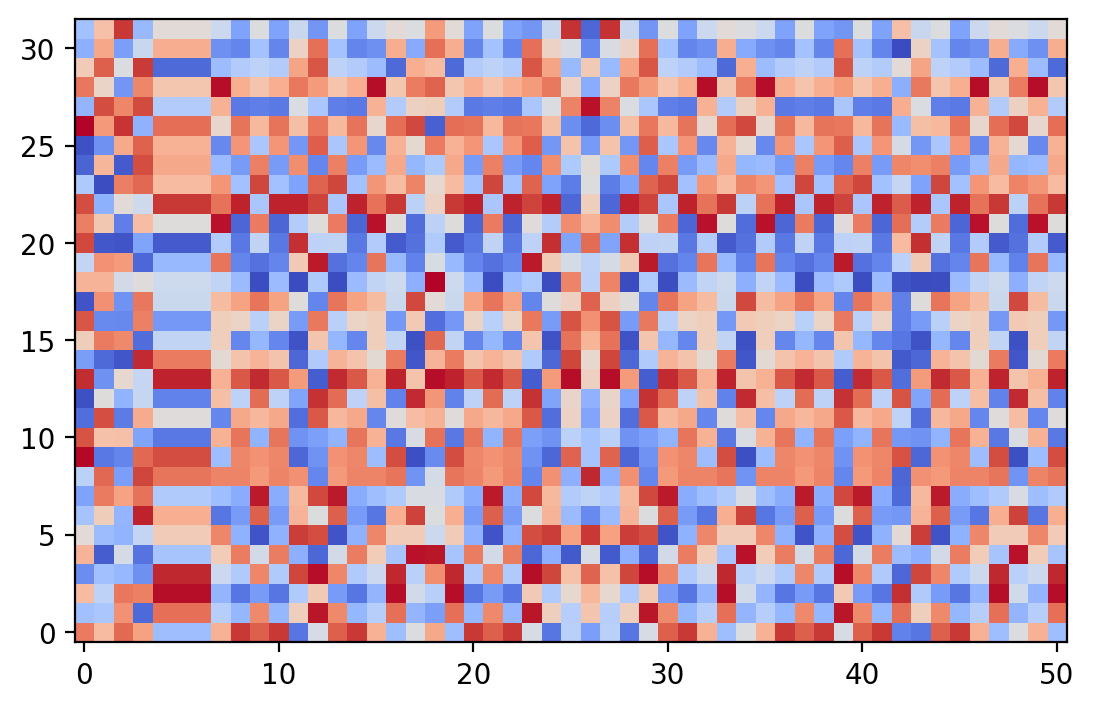

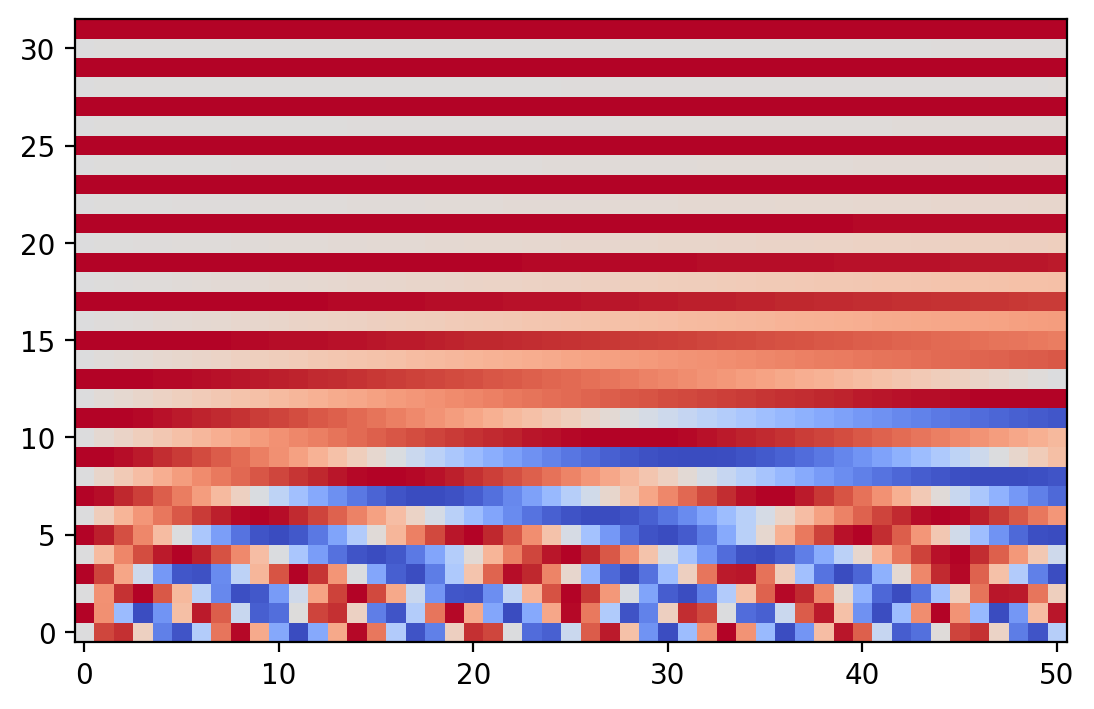

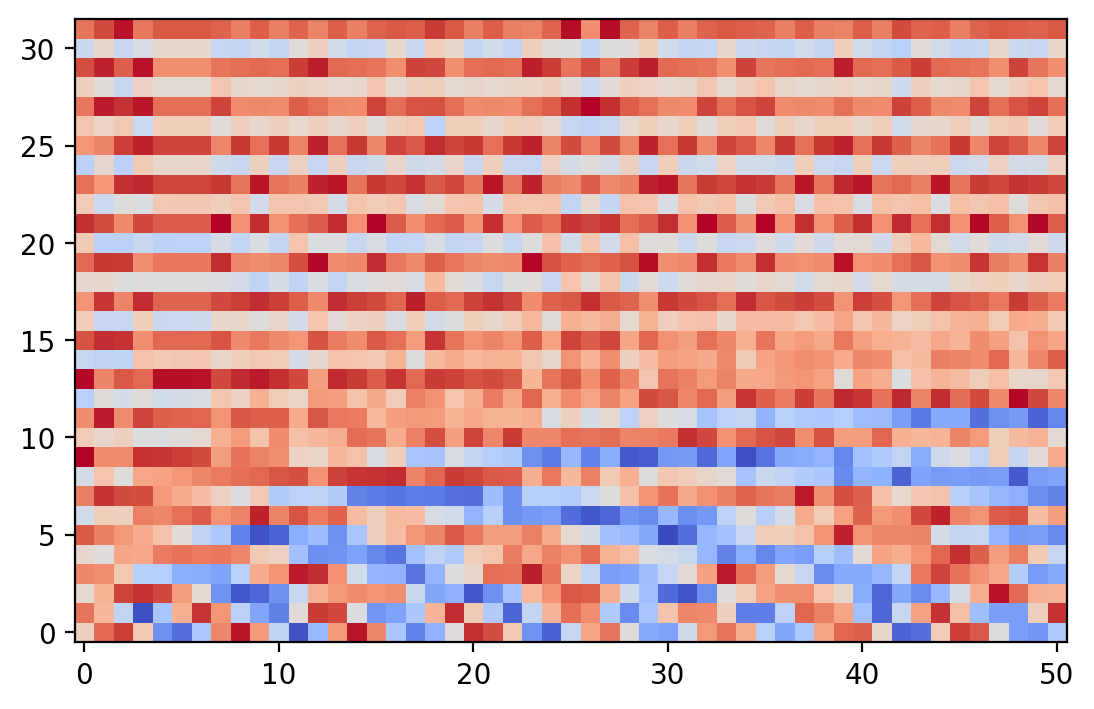

In [17]:
tpe= TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding= tpe.token_emb(example_tokenised_notes)
position_embedding= tpe.pos_emb(token_embedding)
embedding= tpe(example_tokenised_notes)

# Plot Token Embedding heatmap to visualize the token embeddings from the Embedding layer 
#Characteristics:
#  Each row corresponds to a token in the sequence, and each column represents a dimension 
#  in the embedding space.
#  The embeddings are initialized (e.g., using he_uniform), so the pattern appears randomized initially.
#Significance: 
#   Token embeddings encode the semantic or learned representation of each token (note, word, etc.). 
#   Over time, these embeddings are updated during training.
plt.imshow(np.transpose(token_embedding),
          cmap='coolwarm',
          interpolation='nearest',
          origin='lower')

plt.show()

# Position Embedding
# Characteristics:
#   The structure shows distinct bands corresponding to positional patterns.
#   This is expected from sine-based encodings, where different rows (positions) 
#   have varying frequencies but consistent phase patterns.
#   The horizontal lines suggest periodic variations across embedding dimensions.
#Significance: 
#   Positional encodings add unique positional information to the embeddings, enabling the model 
#   to recognize the order of tokens in the sequence.
plt.imshow(
    np.transpose(position_embedding),
    cmap='coolwarm',
    interpolation='nearest',
    origin='lower'
)
plt.show()

# Combined Embedding epresents the final combined embedding (embedding), 
# hich is the sum of the token and position embeddings.
# Characteristics:
#   The final embedding inherits the structure of both token and position embeddings.
#   There is a clear interplay between the randomized token embeddings and the periodic positional patterns.
# Significance: This embedding will be used as input for the transformer layers, encoding both the token 
#   identity and its position within the sequence.        
plt.imshow(
    np.transpose(embedding),
    cmap='coolwarm',
    interpolation='nearest',
    origin='lower'
)
plt.show()

**INTERIM CONCLUSION**

1. Token Embedding (Randomness):
- The token embeddings appear unstructured because they are initialized without pre-training.
- Training will modify these embeddings based on the task.

2. Position Embedding (Structure):
- The periodicity in the position embeddings is expected for sinusoidal positional encodings.
- Each token receives a unique position-related adjustment.

3. Combined Embedding (Rich Representation):
- The final embedding combines semantics (from token embeddings) and positional context, essential for transformers to understand sequences.

## TRANSFORMER MODEL

In [18]:
note_inputs= layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs= layers.Input(shape=(None,), dtype= tf.int32)

note_embeddings= TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)

duration_embeddings= TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)

embeddings= layers.Concatenate()([note_embeddings, duration_embeddings])

x, attention_scores= TransformerBlock(
    N_HEADS,
    KEY_DIM,
    EMBEDDING_DIM,
    FEED_FORWARD_DIM,
    name='attention'
)(embeddings)

note_outputs= layers.Dense(
    notes_vocab_size,
    activation='softmax',
    name='note_outputs'
)(x)

duration_outputs= layers.Dense(
    durations_vocab_size,
    activation='softmax',
    name='duration_outputs'
)(x)


In [19]:
model= models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs] # attention_scores
)

In [20]:
model.compile(
    'adam',
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy()
    ]
)

In [21]:
att_model= models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=attention_scores
)

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 128) │      7,552 │ input_layer[0][0] │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, None, 128) │      3,072 │ input_layer_1[0]… │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, None, 256) │          0 │ token_and_positi… │
│ (Concatenate)       │                   │            │ token_and_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ [(None, None,     │  1,447,424 │ concatenate[0][0] │
│ (TransformerBlock)  │ 256), (None, 5,   │            │                   │
│                     │ None, None)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ note_outputs        │ (None, None, 59)  │     15,163 │ attention[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration_outputs    │ (None, None, 24)  │      6,168 │ attention[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,479,379 (5.64 MB)

 Trainable params: 1,479,379 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
if LOAD_MODEL:
    model.load_weights(CHECKPOINT_PATH + 'music_gan.ckpt')

## TRAIN

In [28]:
model_checkpoint_callback= callbacks.ModelCheckpoint(
    filepath= './checkpoint/musicgan-checkpoint.weights.h5',
    save_weights_only=True,
    save_freq='epoch',
    verbose=0
)

tensorboard_callback= callbacks.TensorBoard(log_dir= LOG_PATH)

In [29]:
music_generator= MusicGenerator(notes_vocab, durations_vocab)

In [ ]:
model.fit(
    ds,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        music_generator
    ]
)

Epoch 1/5000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - duration_outputs_loss: 0.6778 - loss: 3.3226 - note_outputs_loss: 2.6448[['START', 'F#4', 'F#4', 'G4', 'F#4', 'F#4', 'B3', 'C4', 'D4', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'D4', 'C4', 'D4', 'C4', 'B3', 'C4', 'B3', 'C4', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'D4', 'A3', 'B3', 'C4', 'B3', 'C4', 'B3', 'C4', 'B3', 'A3', 'B3', 'B3', 'C4', 'B3'], ['0.0', '0.5', '0.5', '0.5', '1.0', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5', '0.5']]
107/107 ━━━━━━━━━━━━━━━━━━━━ 36s 336ms/step - duration_outputs_loss: 0.6777 - loss: 3.3221 - note_outputs_loss: 2.6443
Epoch 2/5000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - duration_outputs_loss: 0.5972 - loss: 3.1055